# ERA5-Land Monatsdaten - Beispiel Warming Stripes für Städte

Dieses Notebook zeigt die Erstellung sogenannter "Warming Stripes" am Beispiel für die Region Lindau. 
Diese Streifen sind eine minimalistische, aber eindrucksvolle Visualisierung von Temperaturveränderungen über die Jahre hinweg. 
Sie basieren auf ERA5-Land-Daten des Copernicus Climate Data Store (CDS).

*Inhalt des Notebooks:*
1. Datenabruf über die CDS API
2. Verarbeitung und Mittelung der Temperaturdaten
3. Erstellung der Warming Stripes-Grafik

**Informationen zum Datensatz:**
* Quelle: [ERA5-Land Monthly Data](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=overview)
* Author: Tim Tewes
* Notebook-Version: 1.1 (Aktualisiert: März 07, 2025)

## 1. Festlegen des Arbeitsverzeichnisses

Festlegen des Zielverzeichnisses, in dem die Daten heruntergeladen und gespeichert weden sollen

In [ ]:
import os

download_folder = r".data\ERA5-Land"

os.makedirs(download_folder, exist_ok=True)

## 2. Herunterladen des Datensatzes

API-Schlüssel anhand der `.cdsapirc`-Datei auslesen

In [ ]:
import cdsapi
import os

# API key and URL should be stored in a .cdsapirc file or loaded via environment variables
# Example for .cdsapirc content (stored in home directory):
# url: https://cds.climate.copernicus.eu/api/v2
# key: your-uid:your-api-key

c = cdsapi.Client()


Festlegen der Region über eine Bounding Box sowie eines Stadtnamens (für die Plots)

In [8]:
aoi = "Lindau"
bbox = [47.7, 9.6, 47.5, 9.9]

Ausführen des Request-Befehls zum herunterladen der Dateien. Über `year_from` und `year_to` kann der Zeitraum festgelegt werden, der für die Jahresdurchschnittstemperaturen betrachtet wird. Hierbei können nur vollständige Jahre betrachtet werden, da sonst keine repräsentative Jahresdurchschnittstemperatur vorliegt.

In [ ]:
from datetime import datetime

# Variablen für den Zeitraum
year_from = 1950
year_to = 2025

# Überprüfen, ob year_to größer als das letzte vollständige Jahr ist
current_year = datetime.now().year

if year_to >= current_year:
    print(f"Für das Jahr {current_year} kann noch keine Jahresdurchschnittstemperatur ermittelt werden. "
          f"Es werden nur Daten bis zum Jahr {current_year - 1} heruntergeladen.")
    year_to = current_year - 1

# Generiere die Liste der Jahre basierend auf year_from und year_to
years = [str(year) for year in range(year_from, year_to + 1)]


file_path = os.path.join(download_folder, f"era5_{year_from}_{year_to}.grib")

dataset = "reanalysis-era5-land-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["2m_temperature"],
    "year": years,
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "download_format": "unarchived",
    "area": bbox
} 

target = file_path
client = cdsapi.Client()
client.retrieve(dataset, request, target)
grib_file = file_path

## 3. Daten in Dataframe umwandeln

Falls die Daten schon zuvor heruntergeladen wurden, kann die `*.grib` über den folgenden Codeblock festgelegt werden 

In [3]:
# grib_file = r".data\ERA5-Land\era5_1950_2024.grib"
grib_file = r"C:\Users\TT_wo\Documents\Input_Data\ERA5\era5_1950_2024.grib"

Die `*.grib-File` betrachten und analysieren

In [9]:
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset(grib_file, engine="cfgrib")
ds = ds - 273.15 # Kelvin -> Celsius
ds

c:\Users\TT_wo\AppData\Local\Programs\Python\Python313\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 58kB
Dimensions:     (time: 900, latitude: 3, longitude: 4)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-12-01
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 24B 47.7 47.6 47.5
  * longitude   (longitude) float64 32B 9.6 9.7 9.8 9.9
    valid_time  (time) datetime64[ns] 7kB ...
Data variables:
    t2m         (time, latitude, longitude) float32 43kB -2.484 ... -1.238
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-07T15:29 GRIB to CDM+CF via cfgrib-0.9.1...

Testplot für den ersten Zeitpunkt in der Datei erstellen

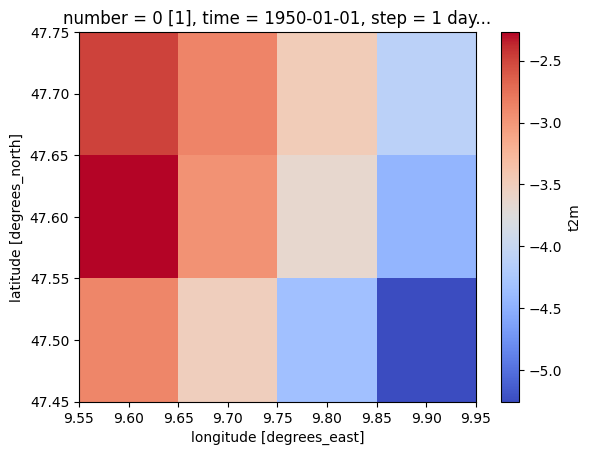

In [10]:
import matplotlib.pyplot as plt
ds.t2m[0].plot(cmap=plt.cm.coolwarm)

Erstellen einer interaktiven Karte mit dem Testplot, um die räumliche Lage der Daten zu sehen 

c:\Users\TT_wo\AppData\Local\Programs\Python\Python313\Lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(



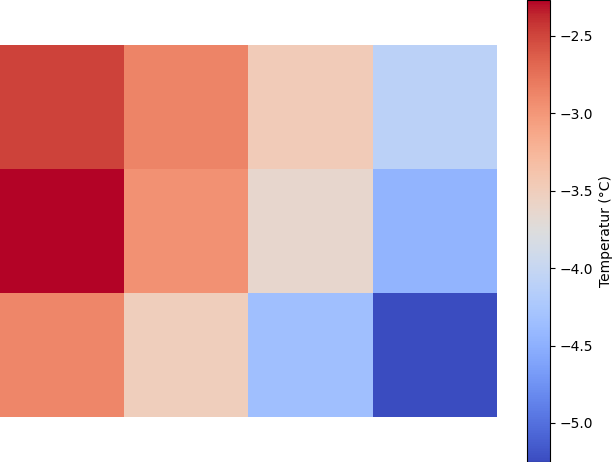

In [11]:
import xarray as xr
import rioxarray  # Geo-Transformationen
import folium
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# GRIB-Datei laden
ds = xr.open_dataset(grib_file, engine="cfgrib")

# Temperatur von Kelvin nach Celsius umrechnen (falls notwendig)
if ds[list(ds.keys())[0]].attrs.get("units", "") == "K":
    ds = ds - 273.15

# Erste Variable extrahieren
var_name = list(ds.keys())[0]  # Nimmt die erste Variable, z. B. Temperatur
data = ds[var_name].isel(time=0)  # Erstes Zeit-Frame

# Koordinaten-Check
if "latitude" in data.dims and "longitude" in data.dims:
    lat_name, lon_name = "latitude", "longitude"
elif "lat" in data.dims and "lon" in data.dims:
    lat_name, lon_name = "lat", "lon"
else:
    raise ValueError("Keine passenden Koordinaten gefunden!")

# In ein GeoTIFF konvertieren (falls nötig)
data.rio.write_crs("EPSG:4326", inplace=True)  # Setze Koordinatensystem
data.rio.to_raster("temp_map.tiff")

# Plot erstellen
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap="coolwarm", origin="upper")
plt.colorbar(label="Temperatur (°C)")
plt.axis("off")
plt.savefig("temp_map.png", bbox_inches="tight", pad_inches=0)
plt.close()

# Bild in Folium einfügen
m = folium.Map(location=[data[lat_name].mean(), data[lon_name].mean()], zoom_start=5)

# Bestimme die Bildgrenzen
lat_min, lat_max = data[lat_name].min().item(), data[lat_name].max().item()
lon_min, lon_max = data[lon_name].min().item(), data[lon_name].max().item()

# Heatmap als Overlay einfügen
folium.raster_layers.ImageOverlay(
    image="temp_map.png",
    bounds=[[lat_min, lon_min], [lat_max, lon_max]],
    opacity=0.6,
).add_to(m)

# Karte anzeigen
m


Optional: Testplot der Jahresmittelwerte für eine einzelne Gitterzelle (über Longitude / Latitude) 

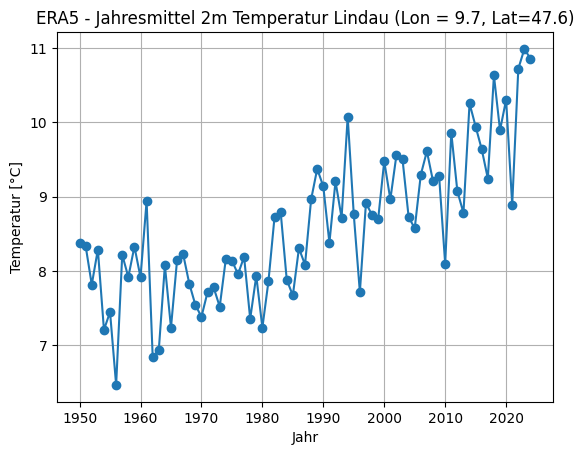

In [12]:
## Plot: Jahresmittelwerte für 1 Kachel

import matplotlib.pyplot as plt

'---------------------'
lon = 9.70  # <--- Hier Wert festlegen
lat = 47.6  # <--- Hier Wert festlegen
'----------------'

# Nächstgelegenen Punkt auswählen
t2m_point = ds.t2m.sel(longitude=lon, latitude=lat, method="nearest")

# Jahresmittelwerte berechnen
t2m_yearly_mean = t2m_point.groupby("time.year").mean()

# Plotten
t2m_yearly_mean.plot(marker='o')
plt.title(f"ERA5 - Jahresmittel 2m Temperatur {aoi} (Lon = {lon}, Lat={lat})")
plt.xlabel("Jahr")
plt.ylabel("Temperatur [°C]")
plt.grid()
plt.show()


Die Jahresmittelwerte pro Kachel ermitteln und in ein Dataframe speichern

In [13]:
### Jahresmittelwerte pro Kachel in Dataframe

import pandas as pd

# Jahresmittel berechnen
t2m_weighted_yearly = ds.t2m.groupby("time.year").mean(dim="time")

# xarray zu DataFrame
df = t2m_weighted_yearly.to_dataframe().reset_index()

# Spalten schöner benennen
df.rename(columns={"year": "Year", "longitude": "Longitude", "latitude": "Latitude", "t2m": "T2m"}, inplace=True)

# Alle Kombinationen aus Year, Longitude, Latitude erzeugen
years = pd.Series(range(1950, 2025), name="Year")
lons = df["Longitude"].unique()
lats = df["Latitude"].unique()

# MultiIndex mit allen Kombinationen erstellen
multi_index = pd.MultiIndex.from_product([years, lats, lons], names=["Year", "Latitude", "Longitude"])

# DataFrame auf diesen Index setzen und fehlende Werte auffüllen (NaN)
df_full = df.set_index(["Year", "Latitude", "Longitude"]).reindex(multi_index).reset_index()

df


,Year,Latitude,Longitude,number,step,surface,T2m
0,1950,47.7,9.6,0,1 days,0.0,8.657158
1,1950,47.7,9.7,0,1 days,0.0,8.245700
2,1950,47.7,9.8,0,1 days,0.0,7.668388
3,1950,47.7,9.9,0,1 days,0.0,7.103284
4,1950,47.6,9.6,0,1 days,0.0,9.096286
...,...,...,...,...,...,...,...
895,2024,47.6,9.9,0,1 days,0.0,9.512746
896,2024,47.5,9.6,0,1 days,0.0,10.905162
897,2024,47.5,9.7,0,1 days,0.0,10.395721
898,2024,47.5,9.8,0,1 days,0.0,9.552623


Die Jahresmittelwerte über alle Kacheln bilden (Statistik: Mean)

In [14]:
### Jahresmittelwert über alle Kacheln bilden

# Über alle Latitude und Longitude pro Jahr mitteln
df_yearly_mean = df.groupby("Year")["T2m"].mean().reset_index()

# Ergebnis anzeigen
df_yearly_mean

,Year,T2m
0,1950,7.717813
1,1951,7.691936
2,1952,7.157888
3,1953,7.657923
4,1954,6.562246
...,...,...
70,2020,9.615430
71,2021,8.208949
72,2022,10.023099
73,2023,10.285693


Nun die Mittelwert für die Referenzperiode ermitteln sowie die jährlichen Abweichungen (Anomalien) berechnen

In [15]:
### Mittelwert für Referenzperiode ermitteln + Anomalien berechnen

# Mittelwert für die Referenzperiode (1971-2000)
reference_period_mean = df_yearly_mean[(df_yearly_mean["Year"] >= 1971) & (df_yearly_mean["Year"] <= 2000)]["T2m"].mean()

# Abweichung der Jahrestemperaturen vom Referenzwert berechnen
df_yearly_mean["Deviation_from_reference"] = df_yearly_mean["T2m"] - reference_period_mean

# Ausgabe des DataFrames
print(df_yearly_mean)


    Year        T2m  Deviation_from_reference
0   1950   7.717813                 -0.004786
1   1951   7.691936                 -0.030663
2   1952   7.157888                 -0.564711
3   1953   7.657923                 -0.064677
4   1954   6.562246                 -1.160354
..   ...        ...                       ...
70  2020   9.615430                  1.892830
71  2021   8.208949                  0.486350
72  2022  10.023099                  2.300499
73  2023  10.285693                  2.563094
74  2024  10.207910                  2.485310

[75 rows x 3 columns]


Den Mittelwert der Jahrestemperatur der Referenzperiode anzeigen lassen.

In [16]:
## Mittelwert der Referenzperiode
reference_period_mean

np.float32(7.7225995)

## 4. Plotten der Warming Stripes

### 4.1 Darstellung 1: Plot der Warming Stripes und Plot der Anomalien 

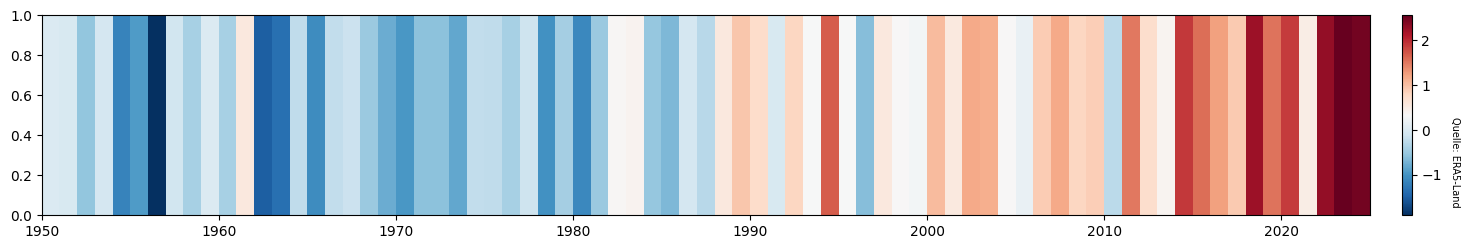

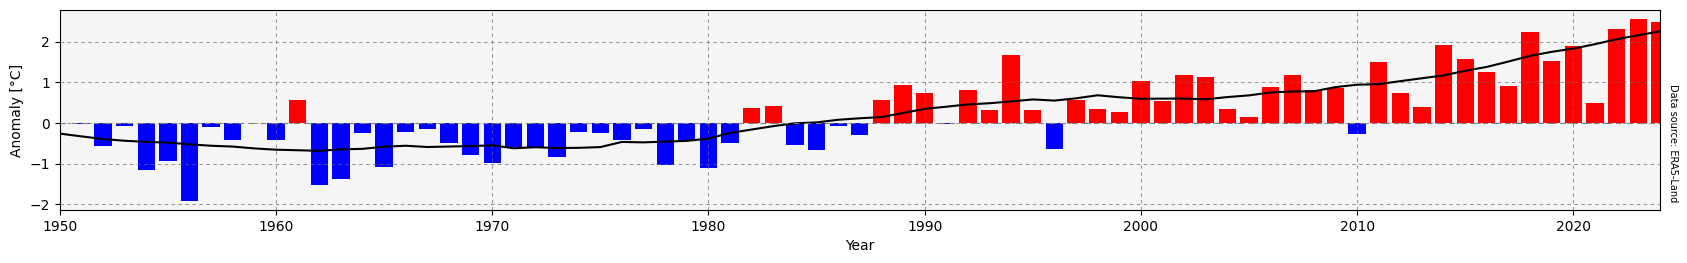

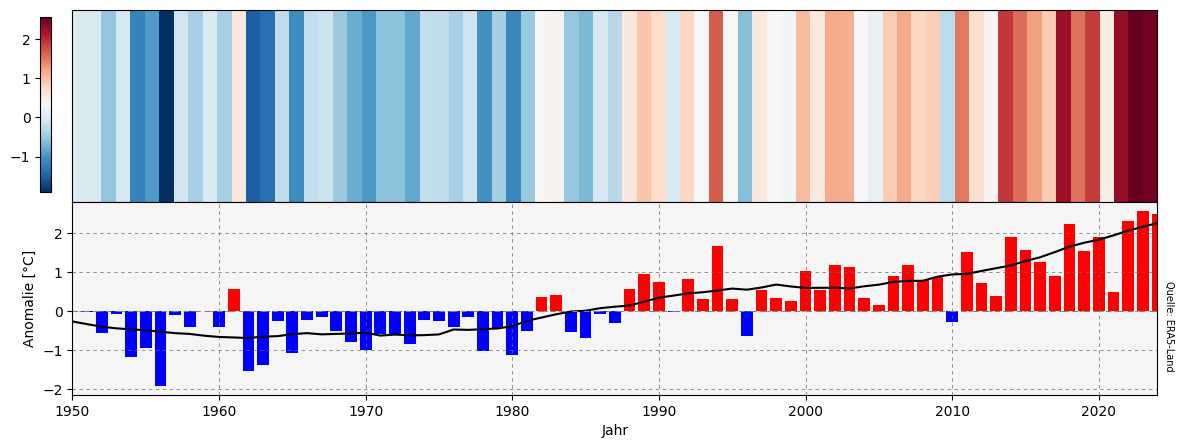

In [17]:
### Plot der Warming Stripes und Anomalien + Kombinierte Grafik

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import scipy.signal

climatology_value = reference_period_mean

def main():

    # Dein DataFrame df_yearly_mean sollte bereits existieren
    # Zum Beispiel:
    # df_yearly_mean = pd.read_csv('deine_datei.csv')

    # Das Jahr und die Abweichungen der Referenz bereithalten
    start_year = df_yearly_mean['Year'].min()
    end_year = df_yearly_mean['Year'].max()

    # Wählen der Colormap
    cmap = 'RdBu_r'

    # Warming Stripes Plot
    fig = plt.figure(figsize=(16, 2))
    ax = fig.add_axes([0, 0, 1, 1])

    # Erstelle eine Sammlung von Rechtecken für jedes Jahr
    rect_coll = PatchCollection([Rectangle((y, 0), 1, 1) for y in df_yearly_mean['Year']])
    rect_coll.set_array(df_yearly_mean['Deviation_from_reference'].values)
    rect_coll.set_cmap(cmap)
    ax.add_collection(rect_coll)

    # Achsenlimits setzen
    ax.set_ylim(0, 1)
    ax.set_xlim(start_year, end_year + 1)

    # Farbskala hinzufügen
    cbar = plt.colorbar(rect_coll, pad=0.02)

    # Text für die Quellenangabe
    plt.figtext(0.88, 0.05, 'Quelle: ERA5-Land', rotation=270, fontsize=7)

    # Plot speichern
    plotfile1 = 'plot_warming_stripes.png'
    fig.savefig(plotfile1, bbox_inches='tight', facecolor='white')

    # Berechnung der Anomalie (Abweichung vom Referenzzeitraum)
    anomaly = df_yearly_mean['T2m'] - reference_period_mean

    # Erstelle den Anomalie-Plot
    fig = plt.figure(figsize=(16, 2))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_facecolor('whitesmoke')

    # Färbe die Balken basierend auf der Anomalie
    colors = ['red' if value > 0 else 'blue' for value in anomaly]
    
    # Plot erstellen
    ax.bar(df_yearly_mean['Year'], anomaly, color=colors)
    ax.plot(df_yearly_mean['Year'], calc_running_mean(anomaly), color='black', linewidth=1.5)
    plt.axhline(y=0., color='gray', linestyle=(0, (5, 5)), linewidth=0.8)

    ax.grid(linestyle=(0, (5, 5)), linewidth=0.5, color='dimgray')
    ax.set_xlim(start_year, end_year)
    ax.set_xlabel('Year')
    ax.set_ylabel('Anomaly [°C]')

    # Text hinzufügen
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    # Quelle anzeigen
    plt.figtext(1.005, 0.05, 'Data source: ERA5-Land', rotation=270, fontsize=7)

    # Plot speichern
    plotfile2 = 'plot_anomaly_bars.png'
    fig.savefig(plotfile2, bbox_inches='tight', facecolor='white')

    # Beide Plots zusammen anzeigen
    fig = plt.figure(figsize=(14, 5))
    gs = fig.add_gridspec(2, 1, hspace=0)

    # --- Erster Plot: Warming Stripes ---
    ax1 = fig.add_subplot(gs[0, 0])
    rect_coll = PatchCollection([Rectangle((y, 0), 1, 1) for y in df_yearly_mean['Year']])
    rect_coll.set_array(df_yearly_mean['Deviation_from_reference'].values)
    rect_coll.set_cmap(cmap)
    ax1.add_collection(rect_coll)
    ax1.set_ylim(0, 1)
    ax1.set_xlim(start_year, end_year + 1)
    ax1.set_xticks([])  # Entfernt die Ticks und damit auch die Jahreszahlen
    ax1.set_xticklabels([])  # Falls doch Text da wäre, explizit leeren
    ax1.xaxis.set_visible(False)  # Komplett die X-Achse unsichtbar machen (optional)
    ax1.set_yticks([])  # Entfernt die Ticks und damit auch die Jahreszahlen
    ax1.set_yticklabels([])  # Falls doch Text da wäre, explizit leeren
    ax1.yaxis.set_visible(False)  # Komplett die X-Achse unsichtbar machen (optional)
       

    # --- Zweiter Plot: Anomalien ---
    
    anomaly = df_yearly_mean['T2m'] - climatology_value # Berechne die Anomalien (Abweichungen vom Referenzwert)
    colors = ['red' if value > 0 else 'blue' for value in anomaly] # Farbgebung je nach Anomalie (rot für positive, blau für negative Abweichungen)
    # Erstelle den Balkenplot der Anomalien
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.bar(df_yearly_mean['Year'], anomaly, color=colors)
    # Gleitender Mittelwert für die Anomalien
    ax2.plot(df_yearly_mean['Year'], calc_running_mean(anomaly), color='black', linewidth=1.5)
    # Horizontale Linie bei 0 (Referenzwert)
    ax2.axhline(y=0., color='gray', linestyle=(0, (5, 5)), linewidth=0.8)
    # Diagramm-Formatierungen
    ax2.set_facecolor('whitesmoke')
    ax2.grid(linestyle=(0, (5, 5)), linewidth=0.5, color='dimgray')
    ax2.set_xlim(start_year, end_year)
    ax2.set_xlabel('Jahr')
    ax2.set_ylabel('Anomalie [°C]')      
    # Farblegende hinzufügen
    ax3 = fig.add_axes([0.102, 0.515, 0.008, 0.35])
    cbar = plt.colorbar(rect_coll, cax=ax3, aspect=100)
    ax3.yaxis.set_ticks_position('left')

    #plt.figtext(0.856, 0.087, '© 2023 Deine Quelle', fontsize=7)
    plt.figtext(0.905, 0.16, 'Quelle: ERA5-Land', rotation=270, fontsize=7)
    # Gesamtbild speichern
    plotfile3 = f'plot_{aoi}_warming_stripes_and_anomalies.png'
    fig.savefig(plotfile3, bbox_inches='tight', facecolor='white')

def calc_running_mean(data, window_length=30, polyorder=3, mode='nearest'):
    return scipy.signal.savgol_filter(data, window_length, polyorder, mode=mode)

if __name__ == '__main__':
    main()


### 4.2 Darstellung 2: Plot der Warmingstripes mit Trendlinie

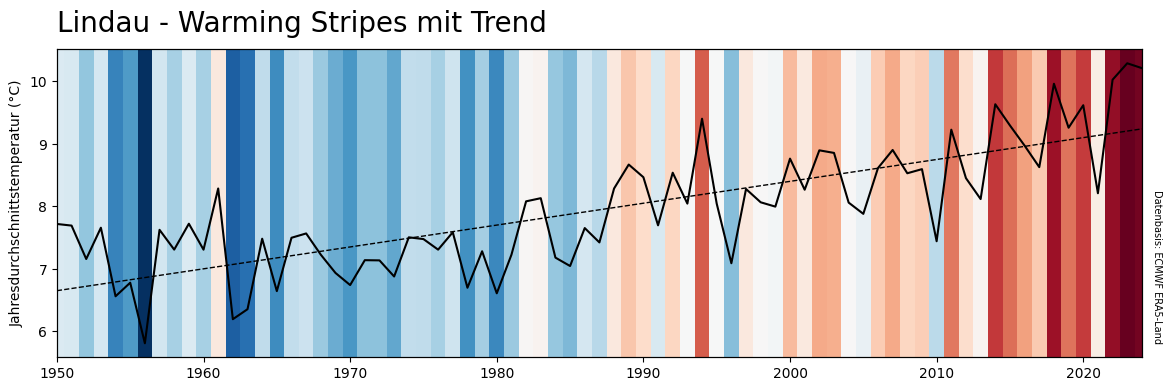

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def plot_warming_stripes_and_trend(df_yearly_mean, reference_period_mean):
    # Daten vorbereiten
    start_year = df_yearly_mean['Year'].min()
    end_year = df_yearly_mean['Year'].max()

    # Plot erstellen
    fig, ax = plt.subplots(figsize=(14, 4))

    # Farbkarte
    cmap = 'RdBu_r'

    # Warming Stripes (basierend auf Abweichung zur Referenzperiode)
    rect_coll = PatchCollection(
        [Rectangle((y - 0.5, 0), 1, 1) for y in df_yearly_mean['Year']],  # Verschiebe die Rechtecke um 0.5 nach links
        zorder=2
    )
    rect_coll.set_array(df_yearly_mean['Deviation_from_reference'])
    rect_coll.set_cmap(cmap)
    ax.add_collection(rect_coll)

    # Achsen anpassen
    ax.set_ylim(0, 1)
    ax.set_xlim(start_year, end_year)
    ax.yaxis.set_visible(False)
    ax.set_title(f'{aoi} - Warming Stripes mit Trend', fontsize=20, loc='left', y=1.03)

    # Zeitreihe hinzufügen
    ax2 = ax.twinx()
    ax2.plot(df_yearly_mean['Year'], df_yearly_mean['T2m'], color='black', linewidth=1.5)
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Jahresdurchschnittstemperatur (°C)')

    # Trend berechnen und hinzufügen
    coef = np.polyfit(df_yearly_mean['Year'], df_yearly_mean['T2m'], 1)
    trend = np.poly1d(coef)
    ax2.plot(df_yearly_mean['Year'], trend(df_yearly_mean['Year']), linestyle='--', color='black', linewidth=1)

    # Quellenangaben
    plt.figtext(0.907, 0.15, 'Datenbasis: ECMWF ERA5-Land', rotation=270, fontsize=7)

    # Plot anzeigen
    plt.show()

    # Plot speichern
    plotfile = f'plot_{aoi}_warming_stripes_trend.png'
    fig.savefig(plotfile, bbox_inches='tight', facecolor='white')
    plt.close(fig)

# Aufruf
plot_warming_stripes_and_trend(df_yearly_mean, reference_period_mean)
